In [43]:
import math
import torch
import hess
import hess.utils as utils
import hess.nets
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from hessian_evals import get_hessian_evals
import matplotlib.pyplot as plt
from gpytorch.utils.lanczos import lanczos_tridiag, lanczos_tridiag_to_diag

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = Net()
model.load_state_dict(torch.load("./model_dict.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

## Is it trained?

In [50]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='~/datasets/', train=True,
                                        download=False, transform=transform)
trainoader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/datasets/', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [59]:
dataiter = iter(testloader)

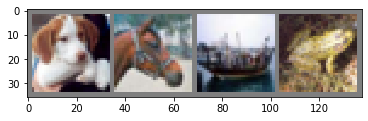

GroundTruth:    dog horse  ship  frog


In [68]:
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [69]:
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog   cat  ship  frog


### it's definitely sort of trained.

## Let's compute some eigenvectors

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [24]:
evals, evecs = get_hessian_evals(loss=criterion,
                     model=model, use_cuda=False, n_eigs=2,
                     loader=trainloader)

In [25]:
print(evals)
print(evecs)

tensor([0., 1.])
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]])


## Well that's broken.

## What's up with HVP and Lanczos?

In [26]:
total_pars = sum(p.numel() for p in model.parameters())

In [38]:
def hvp(rhs):
    padded_rhs = torch.zeros(total_pars, rhs.shape[-1],
                             device=rhs.device, dtype=rhs.dtype)
    print(padded_rhs.shape)
    padded_rhs = utils.unflatten_like(padded_rhs.t(), model.parameters())
    utils.eval_hess_vec_prod(padded_rhs, net=model,
                       criterion=criterion, inputs=None,
                       targets=None, dataloader=trainloader, use_cuda=False)
    full_hvp = utils.gradtensor_to_tensor(model, include_bn=True)
    return full_hvp.unsqueeze(-1)


In [40]:
e1 = torch.zeros(total_pars)
e1[1] = 1.
test = hvp(e1.unsqueeze(-1))

torch.Size([62006, 1])


In [46]:
data = next(iter(trainloader))[0]
dtype = data.dtype
device = data.device
qmat, tmat = lanczos_tridiag(hvp, 3, dtype=dtype,
                          device=device, matrix_shape=(total_pars,
                          total_pars))


torch.Size([62006, 1])
torch.Size([62006, 1])


In [49]:
tmat

tensor([[0., 0., 0.],
        [0., nan, nan],
        [0., nan, 0.]])

## That's broken too :)